In [139]:
from miditok import REMI, get_midi_programs
from miditoolkit import MidiFile
import numpy as np
from pathlib import Path
import json 
import os, glob
from torch.utils.data import Dataset,DataLoader
import torch

In [114]:
# Our parameters
pitch_range = range(21, 109)
beat_res = {(0, 4): 8, (4, 12): 4}
nb_velocities = 32
additional_tokens = {'Chord': True, 'Rest': True, 'Tempo': True, 'Program': False, 'TimeSignature': False,
                     'rest_range': (2, 8),  # (half, 8 beats)
                     'nb_tempos': 32,  # nb of tempo bins
                     'tempo_range': (40, 250)}  # (min, max)

# Creates the tokenizer and loads a MIDI
tokenizer = REMI(pitch_range, beat_res, nb_velocities, additional_tokens, mask=True)
midi = MidiFile('midi_files/train/midi/100005.mid')

In [115]:
from miditok import REMI
from pathlib import Path

# Creates the tokenizer and list the file paths
tokenizer = REMI(mask=True)  # using defaults parameters (constants.py), with MASK tokens for pre-training
train_paths = list(Path('midi_files/train/').glob('**/*.mid'))
val_paths = list(Path('midi_files/validation/').glob('**/*.mid'))
test_paths = list(Path('midi_files/evaluation/').glob('**/*.mid'))
# A validation method to discard MIDIs we do not want
# It can also be used for custom pre-processing, for instance if you want to merge
# some tracks before tokenizing a MIDI file
def midi_valid(midi) -> bool:
    if any(ts.numerator != 4 for ts in midi.time_signature_changes):
        return False  # time signature different from 4/*, 4 beats per bar
    if midi.max_tick < 10 * midi.ticks_per_beat:
        return False  # this MIDI is too short
    return True

# Converts MIDI files to tokens saved as JSON files
tokenizer.tokenize_midi_dataset(train_paths, 'tokenized_train', lambda x: True)
tokenizer.tokenize_midi_dataset(val_paths, 'tokenized_val', lambda x: True)
tokenizer.tokenize_midi_dataset(test_paths, 'tokenized_test', lambda x: True)


Converting MIDIs to tokens:  29%|██▉       | 2817/9552 [00:19<02:29, 45.09it/s]


Converting MIDIs to tokens:  59%|█████▉    | 5657/9552 [00:30<00:14, 269.88it/s]


Converting MIDIs to tokens:  88%|████████▊ | 8368/9552 [00:46<00:04, 273.50it/s]


Converting MIDIs to tokens: 100%|██████████| 9552/9552 [00:51<00:00, 186.88it/s]

Converting MIDIs to tokens:  67%|██████▋   | 1617/2400 [00:06<00:03, 245.43it/s]


Converting MIDIs to tokens: 100%|██████████| 2400/2400 [00:09<00:00, 241.56it/s]

Converting MIDIs to tokens:  51%|█████▏    | 2040/3980 [00:08<00:08, 226.87it/s]


Converting MIDIs to tokens: 100%|██████████| 3980/3980 [00:17<00:00, 229.71it/s]


In [148]:
def preprocess(X,length):
    result = []
    for i in range(len(X)):
        if len(X[i]) > length:
            result.append(X[i][:length])
        elif len(X[i]) < length:
            result.append(X[i] + [0]*(length-len(X[i])))
        else:
            result.append(X[i])
    return result 

def data_loader(path,length):
    data = []
    labels = []
    for filename in glob.glob(os.path.join(path, '*.json')):
        with open(os.path.join(os.getcwd(), filename), 'r') as f:
            d = json.load(f)
            data.append(d['tokens'][0])
            labels.append(d['programs'][0][0])
    return preprocess(data,length),labels

In [150]:
X_train,y_train = data_loader('tokenized_train/',16*16)
X_val,y_val = data_loader('tokenized_val/',16*16)
X_test,y_test = data_loader('tokenized_test/',16*16)

In [162]:

class midi_data(Dataset):
    def __init__(self, X,y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = T.tensor(self.X[idx],dtype=torch.float32)
        label = self.y[idx]
        
        return x, label

In [163]:
train_dataset = midi_data(X_train,y_train)
val_dataset = midi_data(X_val,y_val)
test_dataset = midi_data(X_test,y_test)

In [164]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X_train[0])
NUM_CLASSES = 128
NUM_FEATURES

256

In [188]:
import torch.nn as nn
import torch.optim as optim
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 1024)
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_3 = nn.Linear(512, 256)
        self.layer_out = nn.Linear(256, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [189]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [190]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [191]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=256, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=256, bias=True)
  (layer_out): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [192]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [193]:
from tqdm.notebook import tqdm
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2.82686 | Val Loss: 2.63004 | Train Acc: 24.489| Val Acc: 24.208
Epoch 002: | Train Loss: 2.59099 | Val Loss: 2.50913 | Train Acc: 26.788| Val Acc: 27.417
Epoch 003: | Train Loss: 2.42001 | Val Loss: 2.41687 | Train Acc: 29.824| Val Acc: 28.458
Epoch 004: | Train Loss: 2.23565 | Val Loss: 2.24809 | Train Acc: 33.479| Val Acc: 33.417
Epoch 005: | Train Loss: 2.01630 | Val Loss: 2.16964 | Train Acc: 38.920| Val Acc: 36.708
Epoch 006: | Train Loss: 1.75858 | Val Loss: 1.94693 | Train Acc: 46.237| Val Acc: 43.083
Epoch 007: | Train Loss: 1.49634 | Val Loss: 1.86983 | Train Acc: 53.484| Val Acc: 45.792
Epoch 008: | Train Loss: 1.26005 | Val Loss: 1.81129 | Train Acc: 60.722| Val Acc: 47.417
Epoch 009: | Train Loss: 1.04316 | Val Loss: 1.85084 | Train Acc: 67.725| Val Acc: 47.792
Epoch 010: | Train Loss: 0.88985 | Val Loss: 1.53887 | Train Acc: 72.072| Val Acc: 56.417
Epoch 011: | Train Loss: 0.76782 | Val Loss: 1.65082 | Train Acc: 75.620| Val Acc: 55.583
Epoch 012:

Epoch 093: | Train Loss: 0.06353 | Val Loss: 1.35287 | Train Acc: 98.033| Val Acc: 72.750
Epoch 094: | Train Loss: 0.06511 | Val Loss: 1.21573 | Train Acc: 97.954| Val Acc: 74.792
Epoch 095: | Train Loss: 0.05925 | Val Loss: 1.25523 | Train Acc: 98.084| Val Acc: 74.917
Epoch 096: | Train Loss: 0.05861 | Val Loss: 1.24161 | Train Acc: 98.184| Val Acc: 74.125
Epoch 097: | Train Loss: 0.06529 | Val Loss: 1.21639 | Train Acc: 97.908| Val Acc: 74.875
Epoch 098: | Train Loss: 0.05330 | Val Loss: 1.16235 | Train Acc: 98.384| Val Acc: 76.708
Epoch 099: | Train Loss: 0.06276 | Val Loss: 1.22191 | Train Acc: 97.931| Val Acc: 75.500
Epoch 100: | Train Loss: 0.06021 | Val Loss: 1.18483 | Train Acc: 98.089| Val Acc: 75.250
Epoch 101: | Train Loss: 0.06055 | Val Loss: 1.11165 | Train Acc: 97.937| Val Acc: 76.375
Epoch 102: | Train Loss: 0.05851 | Val Loss: 1.19699 | Train Acc: 98.115| Val Acc: 75.375
Epoch 103: | Train Loss: 0.05359 | Val Loss: 1.28358 | Train Acc: 98.181| Val Acc: 75.375
Epoch 104:

Epoch 185: | Train Loss: 0.03316 | Val Loss: 1.21379 | Train Acc: 98.976| Val Acc: 77.167
Epoch 186: | Train Loss: 0.03214 | Val Loss: 1.32718 | Train Acc: 99.024| Val Acc: 77.792
Epoch 187: | Train Loss: 0.02863 | Val Loss: 1.16265 | Train Acc: 99.072| Val Acc: 77.583
Epoch 188: | Train Loss: 0.02846 | Val Loss: 1.24924 | Train Acc: 99.107| Val Acc: 76.875
Epoch 189: | Train Loss: 0.02802 | Val Loss: 1.14645 | Train Acc: 99.096| Val Acc: 77.917
Epoch 190: | Train Loss: 0.03273 | Val Loss: 1.18809 | Train Acc: 99.060| Val Acc: 77.375
Epoch 191: | Train Loss: 0.03318 | Val Loss: 1.20020 | Train Acc: 98.916| Val Acc: 76.917
Epoch 192: | Train Loss: 0.02608 | Val Loss: 1.30354 | Train Acc: 99.139| Val Acc: 76.667
Epoch 193: | Train Loss: 0.03413 | Val Loss: 1.24095 | Train Acc: 99.022| Val Acc: 76.875
Epoch 194: | Train Loss: 0.02873 | Val Loss: 1.23020 | Train Acc: 99.199| Val Acc: 76.667
Epoch 195: | Train Loss: 0.03427 | Val Loss: 1.27969 | Train Acc: 98.982| Val Acc: 76.000
Epoch 196:

Epoch 277: | Train Loss: 0.02003 | Val Loss: 1.28654 | Train Acc: 99.361| Val Acc: 78.167
Epoch 278: | Train Loss: 0.02194 | Val Loss: 1.48310 | Train Acc: 99.367| Val Acc: 76.125
Epoch 279: | Train Loss: 0.02570 | Val Loss: 1.31493 | Train Acc: 99.180| Val Acc: 76.875
Epoch 280: | Train Loss: 0.02255 | Val Loss: 1.30208 | Train Acc: 99.373| Val Acc: 77.417
Epoch 281: | Train Loss: 0.02469 | Val Loss: 1.30238 | Train Acc: 99.253| Val Acc: 78.375
Epoch 282: | Train Loss: 0.02178 | Val Loss: 1.31929 | Train Acc: 99.289| Val Acc: 77.250
Epoch 283: | Train Loss: 0.02464 | Val Loss: 1.29872 | Train Acc: 99.269| Val Acc: 78.542
Epoch 284: | Train Loss: 0.02289 | Val Loss: 1.40866 | Train Acc: 99.383| Val Acc: 76.208
Epoch 285: | Train Loss: 0.02436 | Val Loss: 1.36408 | Train Acc: 99.301| Val Acc: 76.667
Epoch 286: | Train Loss: 0.01737 | Val Loss: 1.30773 | Train Acc: 99.482| Val Acc: 78.167
Epoch 287: | Train Loss: 0.02874 | Val Loss: 1.29653 | Train Acc: 99.151| Val Acc: 76.958
Epoch 288:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

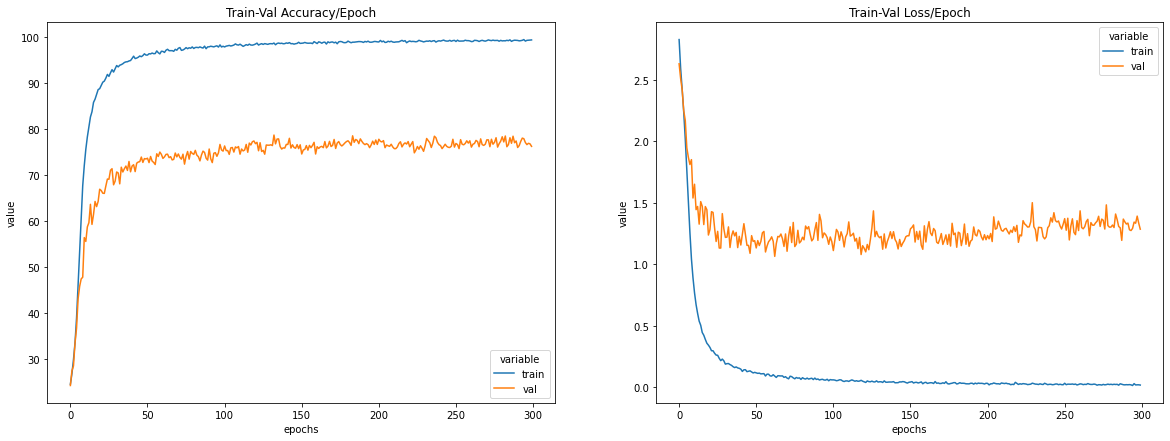

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')